In [81]:
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import BaseMessage # The foundational class for all message types in LangGraph
from langchain_core.messages import ToolMessage # Passes data back to LLM after it calls a tool such as the content and the tool_call_id
from langchain_core.messages import SystemMessage # Message for providing instructions to the LLM
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode

In [82]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [83]:
@tool
def add(a: int, b:int):
    """Add two integers.

    Args:
        a: First integer
        b: Second integer
    """
    return a + b 

In [84]:
@tool
def subtract(a: int, b: int):
    """Subtraction function"""
    return a - b

In [85]:
@tool
def multiply(a: int, b: int):
    """Multiplication function"""
    return a * b

In [86]:
tools = [add, subtract, multiply]

In [87]:
from langchain_ollama import ChatOllama
llm = ChatOllama(temperature=0.0, model="llama3.2").bind_tools(tools)

In [90]:

def model_call(state:AgentState) -> AgentState:
    system_prompt = SystemMessage(content=
        "You are my AI assistant, please answer my query to the best of your ability."
    )
    response = llm.invoke([system_prompt] + state["messages"])
    return {"messages": [response]}

In [91]:
def should_continue(state: AgentState): 
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls: 
        return "end"
    else:
        return "continue"

In [92]:
graph = StateGraph(AgentState)
graph.add_node("custom_agent", model_call)


tool_node = ToolNode(tools=tools)
graph.add_node("tools", tool_node)

graph.set_entry_point("custom_agent")

graph.add_conditional_edges(
    "custom_agent",
    should_continue,
    {
        "continue": "tools",
        "end": END,
    },
)

graph.add_edge("tools", "custom_agent")

app = graph.compile()

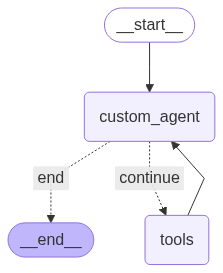

In [93]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [94]:
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

In [97]:
inputs = {"messages": [("user", "Add 40 + 12 then multi 10.")]}
print_stream(app.stream(inputs, stream_mode="values"))

================================ Human Message =================================

Add 40 + 12 then multi 10.
================================== Ai Message ==================================
Tool Calls:
  add (1b37bb50-ce2d-4d81-9e98-17294402d73e)
 Call ID: 1b37bb50-ce2d-4d81-9e98-17294402d73e
  Args:
    a: 40
    b: 12
  multiply (240e8a0a-74d0-4794-96f0-3e4e626af9ca)
 Call ID: 240e8a0a-74d0-4794-96f0-3e4e626af9ca
  Args:
    a: 10
    b:
================================= Tool Message =================================
Name: multiply

Error: 1 validation error for multiply
b
  Input should be a valid integer, unable to parse string as an integer [type=int_parsing, input_value='', input_type=str]
    For further information visit https://errors.pydantic.dev/2.11/v/int_parsing
 Please fix your mistakes.
================================== Ai Message ==================================

To calculate the result of multiplying 10 by the sum of 40 and 12, I will first add 40 and 12, then multi